# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.380547,True,4.882282
1,-0.104944,True,4.895574
2,-1.003072,True,3.393802
3,-0.478806,False,0.591752
4,-0.223874,True,6.198598
...,...,...,...
995,-1.992269,False,0.071315
996,0.093324,True,6.352915
997,1.112831,True,6.326246
998,1.041031,False,1.594677


<AxesSubplot:xlabel='v0'>

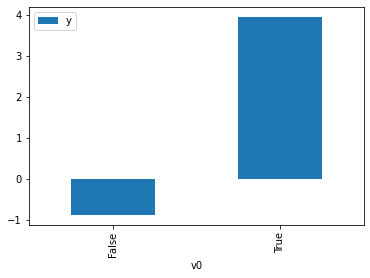

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

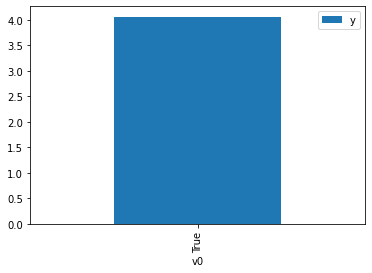

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.290766,False,-2.293952,0.609782,1.639931
1,0.015468,False,-0.943643,0.506532,1.974209
2,-1.489570,False,-3.037369,0.890084,1.123490
3,-0.360866,False,-0.045030,0.632417,1.581236
4,-1.489986,False,-1.590914,0.890140,1.123419
...,...,...,...,...,...
995,-1.173920,False,-3.671956,0.840024,1.190442
996,0.396594,False,-0.699937,0.378265,2.643648
997,-0.380898,False,-0.200036,0.638784,1.565475
998,-0.558245,False,0.028922,0.692849,1.443315


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.605745,True,6.438499,0.686531,1.456599
1,0.365219,True,6.636170,0.611556,1.635172
2,-1.583881,True,3.997905,0.097878,10.216793
3,-0.472744,True,4.040587,0.332669,3.005987
4,0.848507,True,4.702901,0.753452,1.327224
...,...,...,...,...,...
995,-0.646546,True,3.733570,0.281981,3.546339
996,-0.018544,True,2.580610,0.481807,2.075522
997,-0.169994,True,5.004565,0.430294,2.323991
998,-2.286385,True,2.921972,0.039729,25.170241


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.917
Model:                            OLS   Adj. R-squared (uncentered):              0.917
Method:                 Least Squares   F-statistic:                              5522.
Date:                Thu, 18 Aug 2022   Prob (F-statistic):                        0.00
Time:                        17:46:06   Log-Likelihood:                         -1457.3
No. Observations:                1000   AIC:                                      2919.
Df Residuals:                     998   BIC:                                      2928.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.3229      0.028     46.678      0.000       1.267       1.379
x2             5.0736      0.056     91.370      0.000       4.965       5.183
==============================================================================
Omnibus:                        0.162   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.922   Jarque-Bera (JB):                0.126
Skew:                          -0.027   Prob(JB):                        0.939
Kurtosis:                       3.014   Cond. No.                         1.96
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""